In [122]:
from src.nn.cnn.model.conv_network import ConvNetwork
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from scipy import misc
import math
from tqdm import tqdm
from src.gimp.draw.draw_triangle import draw_triangle as _draw_triangle
from src.gimp.draw.draw_line import draw_line as _draw_line
import os

class Encoder(object):
    def __init__(self):
        self.shape_predictor = ConvNetwork('../result/model/classifier/classifier-43')
        self.representation_predictors = [
            ConvNetwork('../result/model/ellipse/ellipse-8'),
            ConvNetwork('../result/model/rectangle/rectangle-23'),
            ConvNetwork('../result/model/line/line-6'),
            ConvNetwork('../result/model/triangle/triangle-8')
        ]
    
    def encode(self, img):
        action = np.argmax(self.shape_predictor.generate_args(img))
        args = self.representation_predictors[action].generate_args(img)
        return action, args
    
    
class Decoder(object):
    def __init__(self):
        pass
    
    def decode(self, encoded, size=100):
        def sigmoid(x):
            return 1/(1+np.exp(-x))
        
        action, args = encoded
        args = sigmoid(args)
        if action == 0:
            self.draw_ellipse(args, size)
        elif action == 1:
            self.draw_rectangle(args, size)
        elif action == 2:
            self.draw_line(args, size)
        else:
            self.draw_triangle(args, size)
            
    def draw(self, y_, shape, size):
        path_to_image_results = '../result/gimp_images/nn/shapes'
        name = 'jupyter_test.png'
        os.system('python ../src/gimp/draw/draw_selection_shape.py --name {} --shape {} --size {} --r {} --g {} --b {} --a {} --x {} --y {} --w {} --h {} --rotation {}'\
                  .format(name, shape, size, y_[0], y_[1], y_[2], y_[3], y_[4], y_[5], y_[6], y_[7], y_[8]))
        image_data = plt.imread('%s/%s' % (path_to_image_results, name))[:,:,:3]
        plt.imshow(image_data)

    def draw_rectangle(self, y, size):
        self.draw(y, 'rectangle', size)

    def draw_ellipse(self, y, size):
        self.draw(y, 'ellipse', size)

    def draw_triangle(self, y, size):
        path_to_image_results = '../result/gimp_images/nn/shapes'
        name = 'jupyter_test.png'
        _draw_triangle(name, size, y[0], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9])
        image_data = plt.imread('%s/%s' % (path_to_image_results, name))[:,:,:3]
        plt.imshow(image_data)

    def draw_line(self, y, size):
        path_to_image_results = '../result/gimp_images/nn/shapes'
        name = 'jupyter_test.png'
        _draw_line(name, size, y[0], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8])
        image_data = plt.imread('%s/%s' % (path_to_image_results, name))[:,:,:3]
        plt.imshow(image_data)
            
    
    
def load_data(name):
    path = "../data/dataset/random_shape_classification/"
    X = np.load(path + "%s_X_1.npy" % name, mmap_mode="r")
    Y = np.load(path + "%s_Y_1.npy" % name, mmap_mode="r")
    return X, Y

def show_source(i):
    plt.imshow(np.ones(X[i].shape) + X[i])

In [123]:
encoder = Encoder()
decoder = Decoder()

INFO:tensorflow:Restoring parameters from ../result/model/classifier/classifier-43
INFO:tensorflow:Restoring parameters from ../result/model/ellipse/ellipse-8
INFO:tensorflow:Restoring parameters from ../result/model/rectangle/rectangle-23
INFO:tensorflow:Restoring parameters from ../result/model/line/line-6
INFO:tensorflow:Restoring parameters from ../result/model/triangle/triangle-8


In [152]:
X, _ = load_data('test')

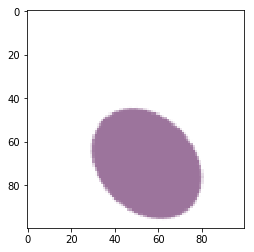

In [153]:
index = np.random.randint(0, X.shape[0])
show_source(index)

In [154]:
encoded = encoder.encode(X[index])
print(encoded)

(0, array([-0.07297273, -1.1042023 , -0.08272161,  0.8761895 , -0.40991384,
       -0.06669443, -0.33017713,  0.04577467, -0.5448908 ], dtype=float32))


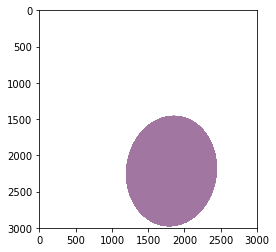

In [156]:
decoder.decode(encoded, size=3000)